In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X *= 100
feature_names = np.array(['x1', 'x2'])

In [3]:
pd.DataFrame(X, columns=feature_names).describe()

,x1,x2
count,300.000000,300.000000
mean,84.138769,9.979408
std,77.917955,117.978412
min,-181.190181,-374.445022
25%,35.786394,-59.339309
50%,83.158128,34.019343
75%,131.776480,93.596696
max,307.157526,258.940851


In [4]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X, y)
lm.intercept_, lm.coef_

(array([1.11018683]), array([[-0.02146303,  0.02909487]]))

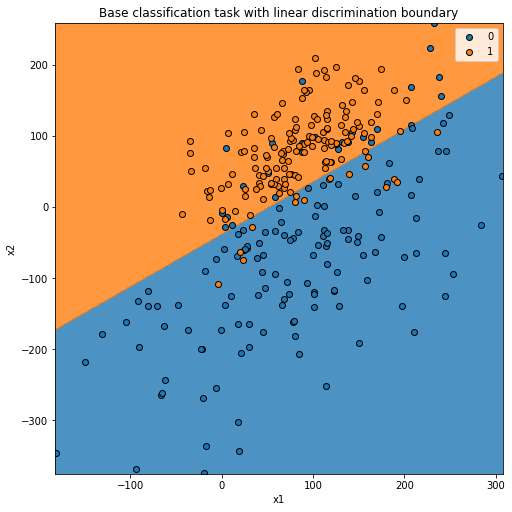

In [5]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=lm.predict, class_names=lm.classes_,
                       fig=fig, ax=ax)

In [6]:
clf_a = lm

In [7]:
clf_b = LogisticRegression()
X2 = X.copy()
X2[:, 0] = 0
clf_b.fit(X2, y)
clf_b.intercept_, lm.coef_

(array([-0.38103095]), array([[-0.02146303,  0.02909487]]))

In [8]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

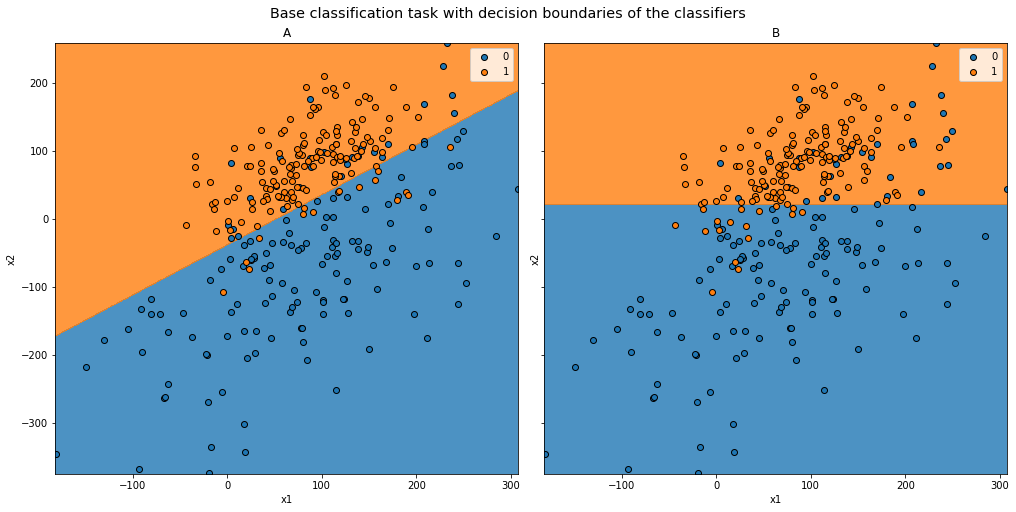

In [9]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

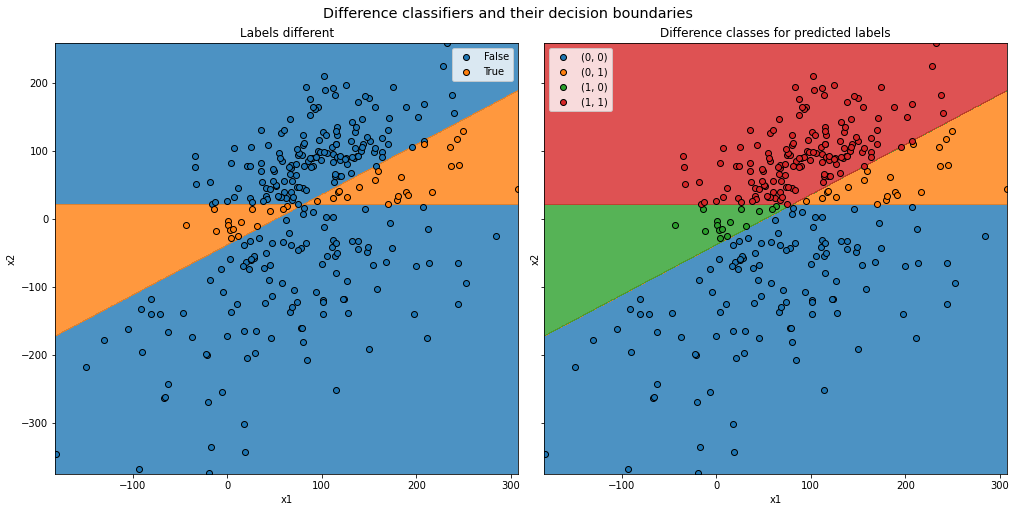

In [10]:
comparer.plot_decision_boundaries(X)

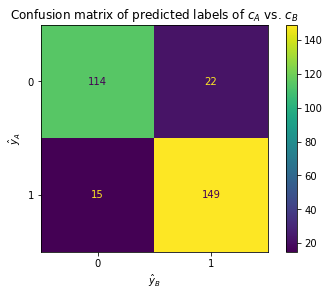

In [11]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [12]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 5.78 s, sys: 121 ms, total: 5.9 s
Wall time: 6.25 s


In [13]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((300, 2), (0,), (0,))

In [14]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

A relies on both features, whereas B only relies on one feature.

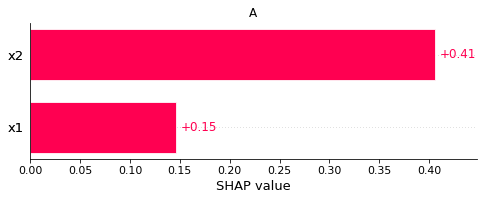

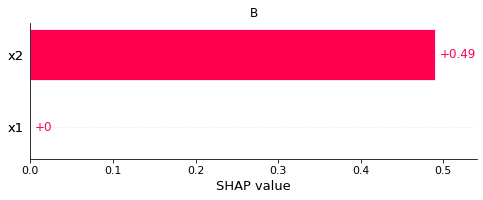

In [15]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [16]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [17]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.labels[:, [feature_idx], 1])
    plot_feature_effects(explanations.indiv.labels[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

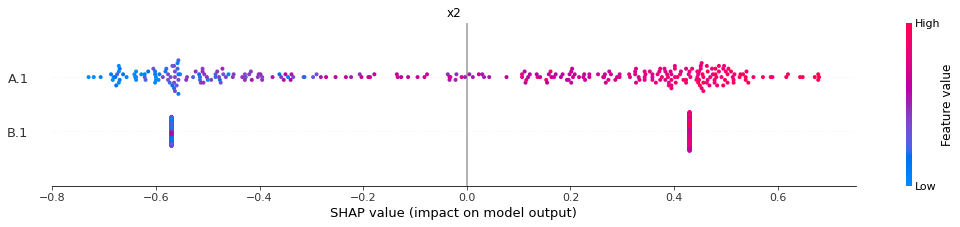

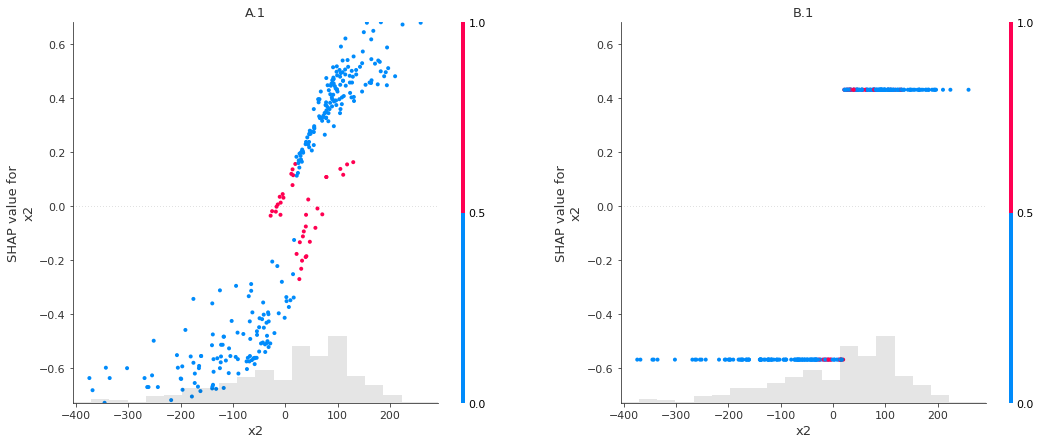

In [18]:
plot_next_feature()

The partial dependence of x2 on B is constant.

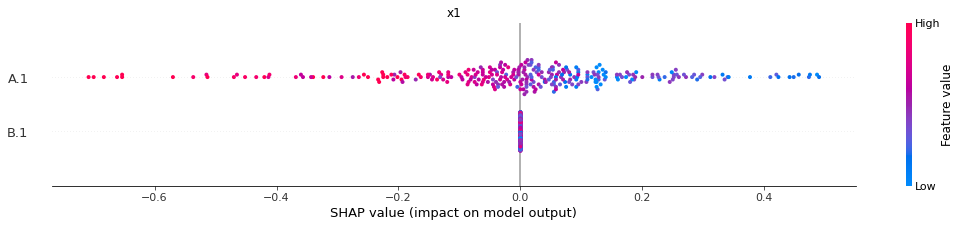

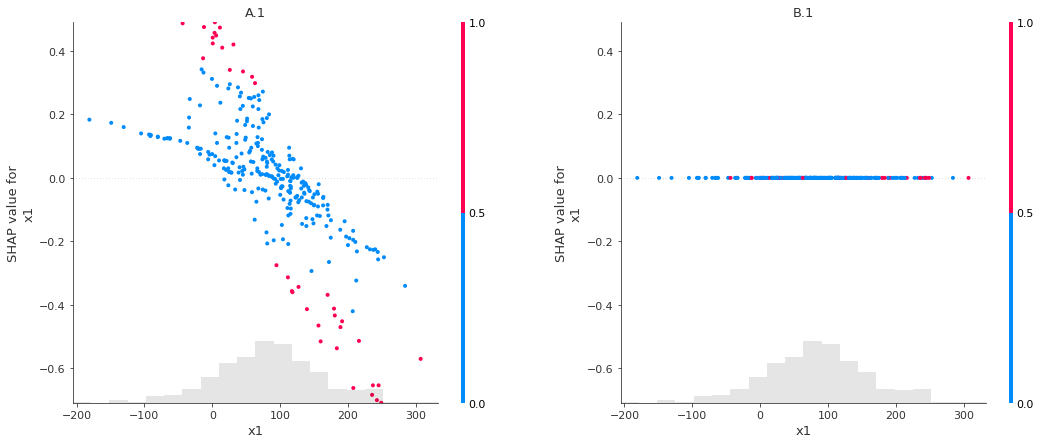

In [19]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

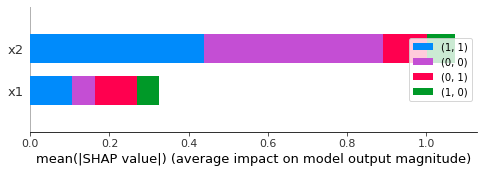

In [20]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(explanations.mclass_diff.labels)

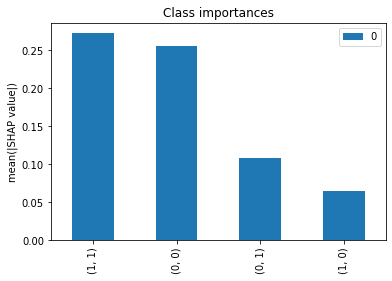

In [21]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [22]:
class_order = np.sort(class_order)

In [23]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order])
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order], color=is_pred_diff)
it = iter(feature_order)

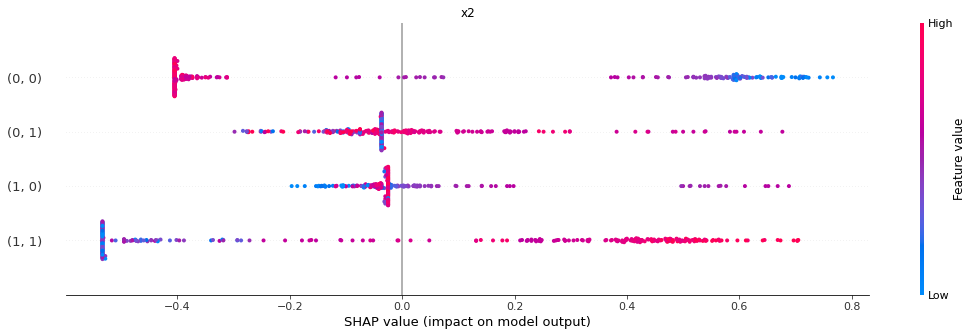

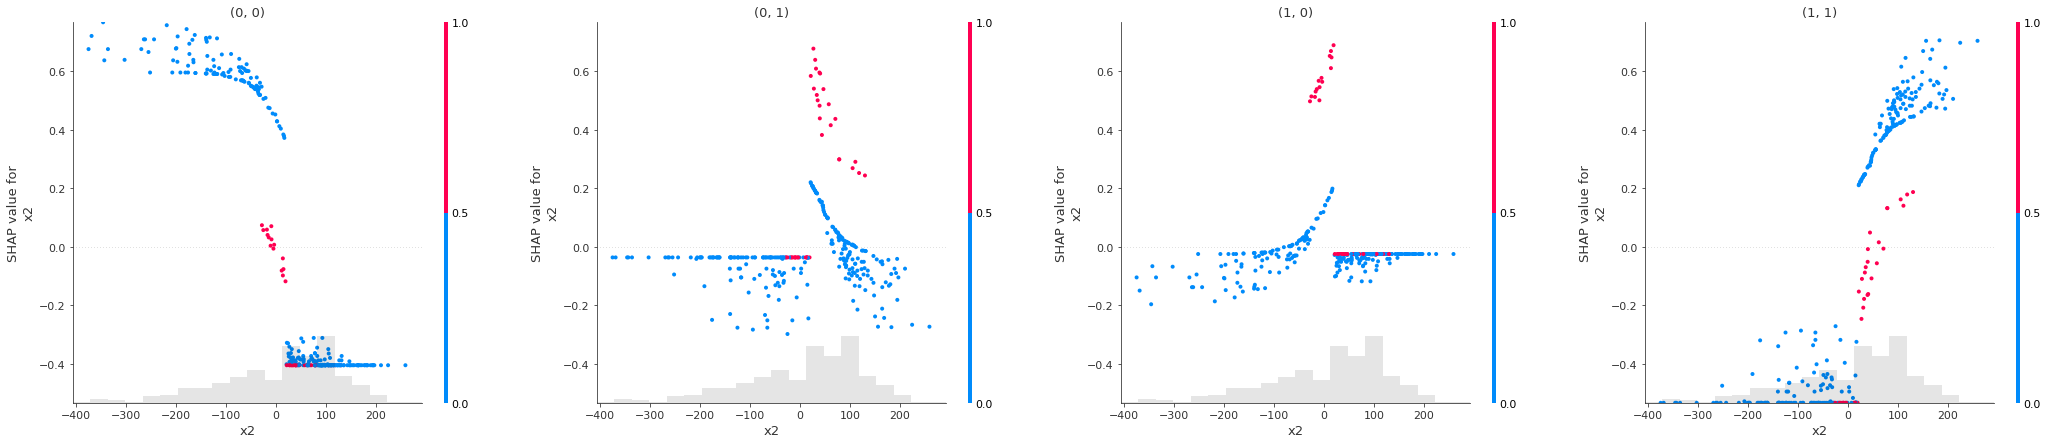

In [24]:
plot_next_feature()

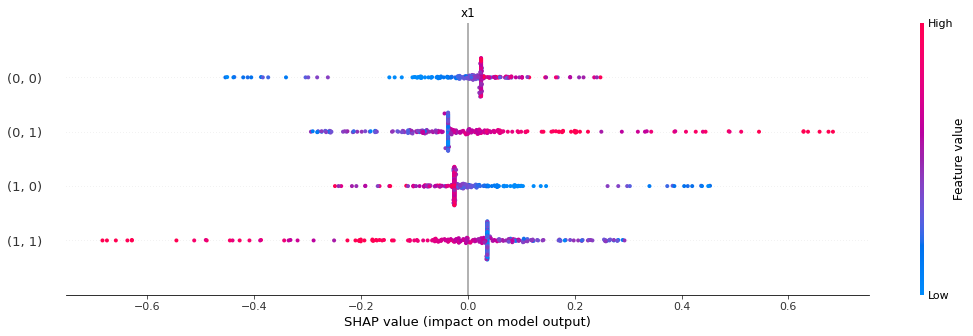

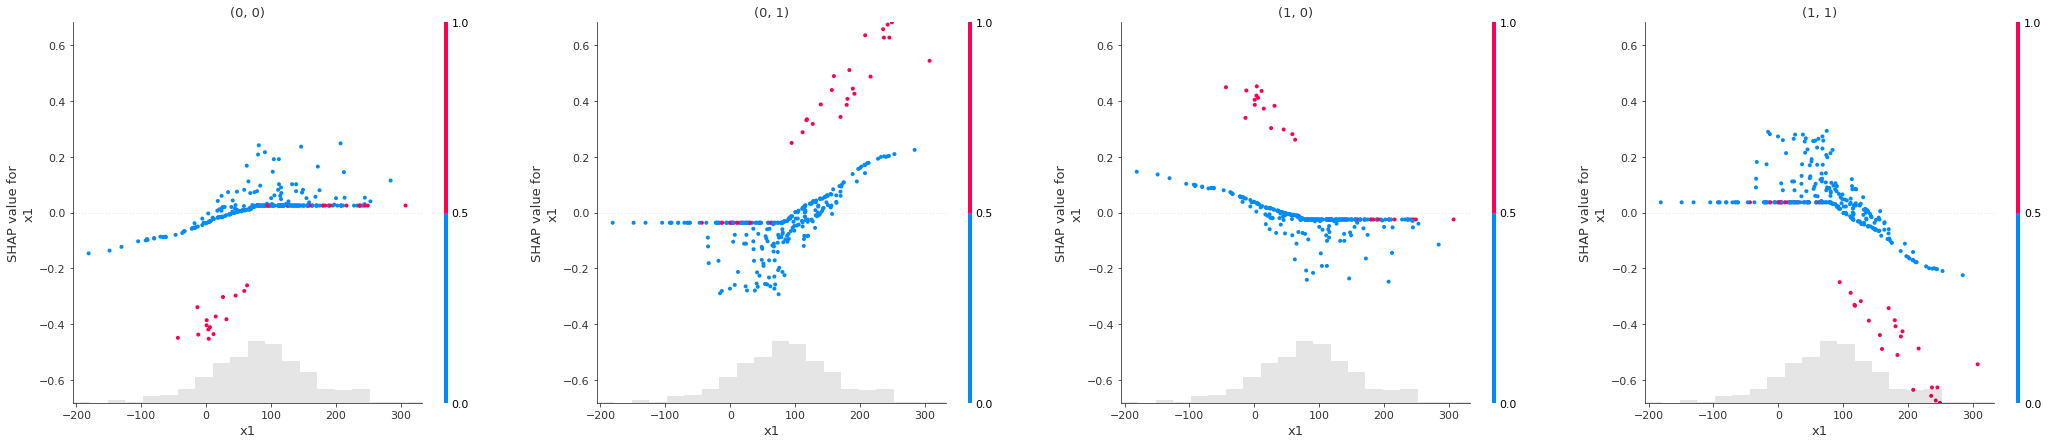

In [25]:
plot_next_feature()

# Local Explanations

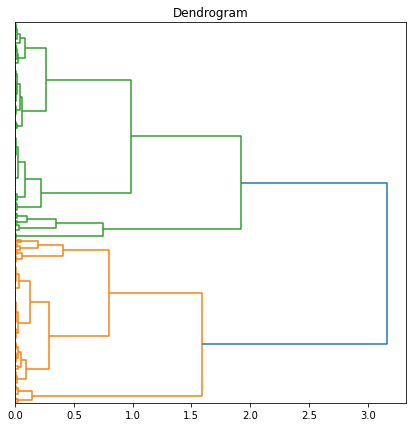

In [26]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.labels)
plot_dendrogram(linkage_matrix)

Using $n=2$ yields a clustering where each cluster contains one difference class and one equality class.

In [29]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=2)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,114,0,15,0
c2,0,22,0,149


In [30]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    classes = np.unique(pred_class_names)
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes, classes
cluster_it = iter(clusters_of_interest)

## 1. Cluster

These feature value distributions are different locally compared to the global level:
- x2 only reaches up to 19

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x2 was higher, the effect would shift towards $(1,1)$: Setting it to 200 changes all predictions to this class.

Using the local explanations I can interpret that:
- if x2 was lower, the effect would shift towards $(0,0)$: setting it to -200 changes all predictions of instances classified differently to this class and leaves others unchanged.
- if x1 was higher, the effect would shift towards $(0,0)$: setting it to 200 changes all predictions of instances classified differently to this class and leaves others unchanged.

In [31]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,114,0,15,0


In [32]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,129.000000,129.000000
mean,55.088219,-99.773632
std,86.177646,90.345925
min,-181.190181,-374.445022
25%,3.332313,-140.051568
50%,47.345147,-71.524373
75%,111.884657,-32.811675
max,284.147959,19.245562


In [34]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = 200
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",114.0,NaN
"(1, 1)",NaN,114.0


,before,after
"(1, 0)",15.0,NaN
"(1, 1)",NaN,15.0


### SHAP-based Difference Classifier Explanations

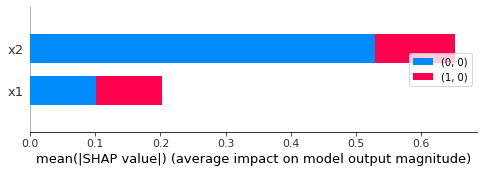

In [35]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

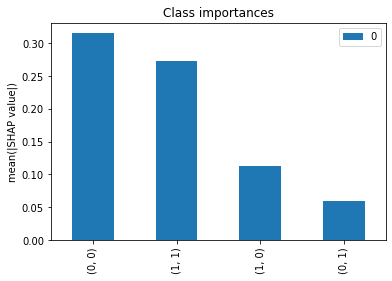

In [36]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [37]:
class_order = np.sort(class_order)

In [38]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]][:, :, class_order])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]][:, :, class_order], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

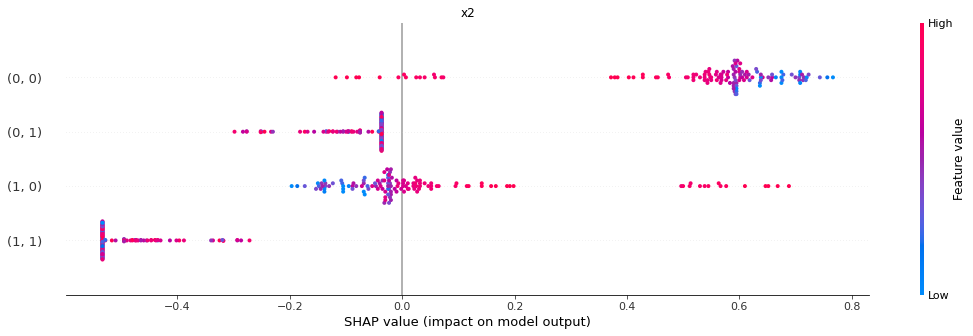

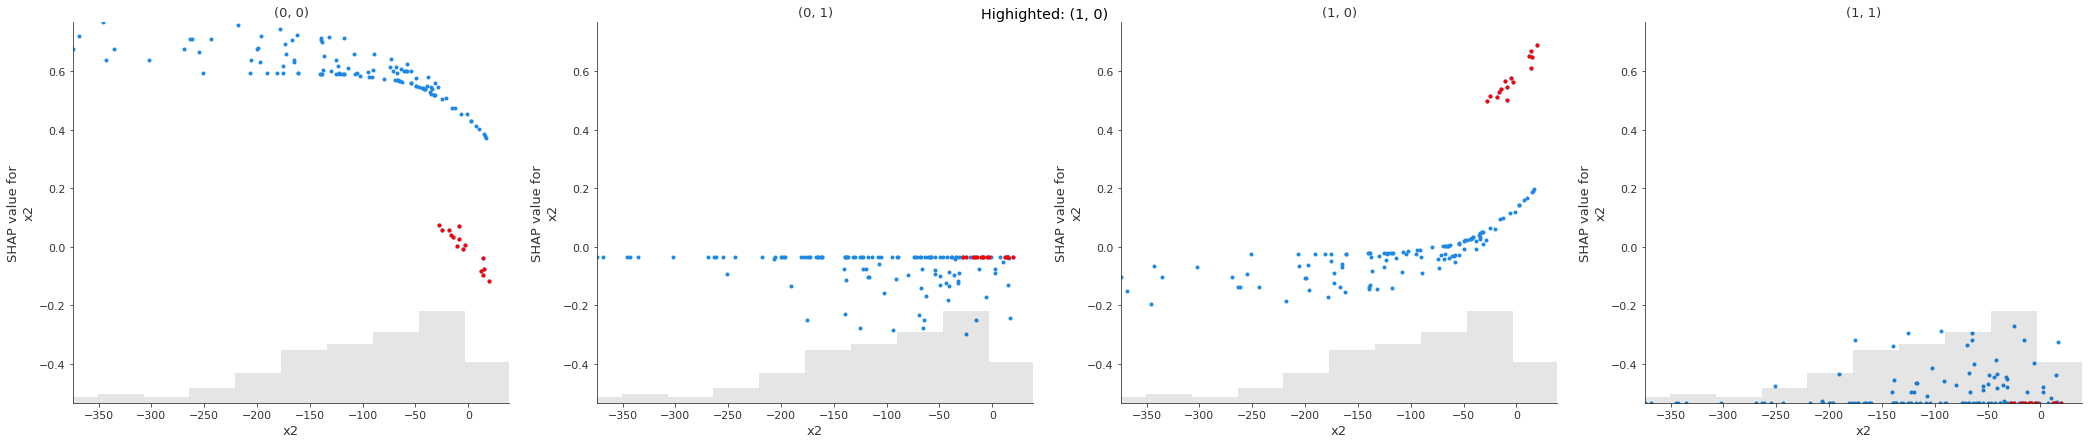

In [39]:
plot_next_feature()

In [41]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = -200
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",114,114


,before,after
"(0, 0)",NaN,15.0
"(1, 0)",15.0,NaN


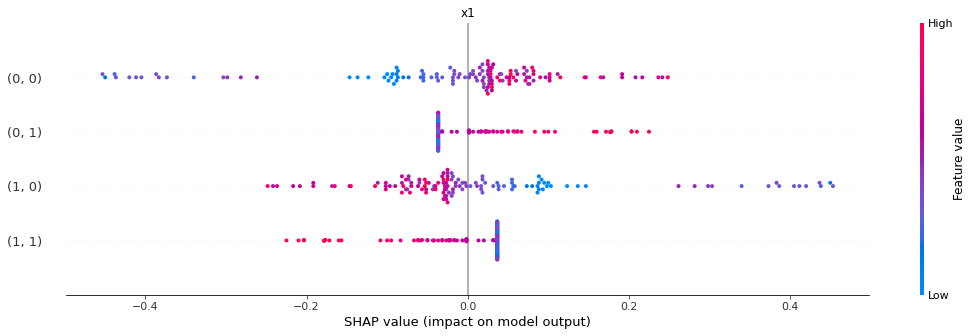

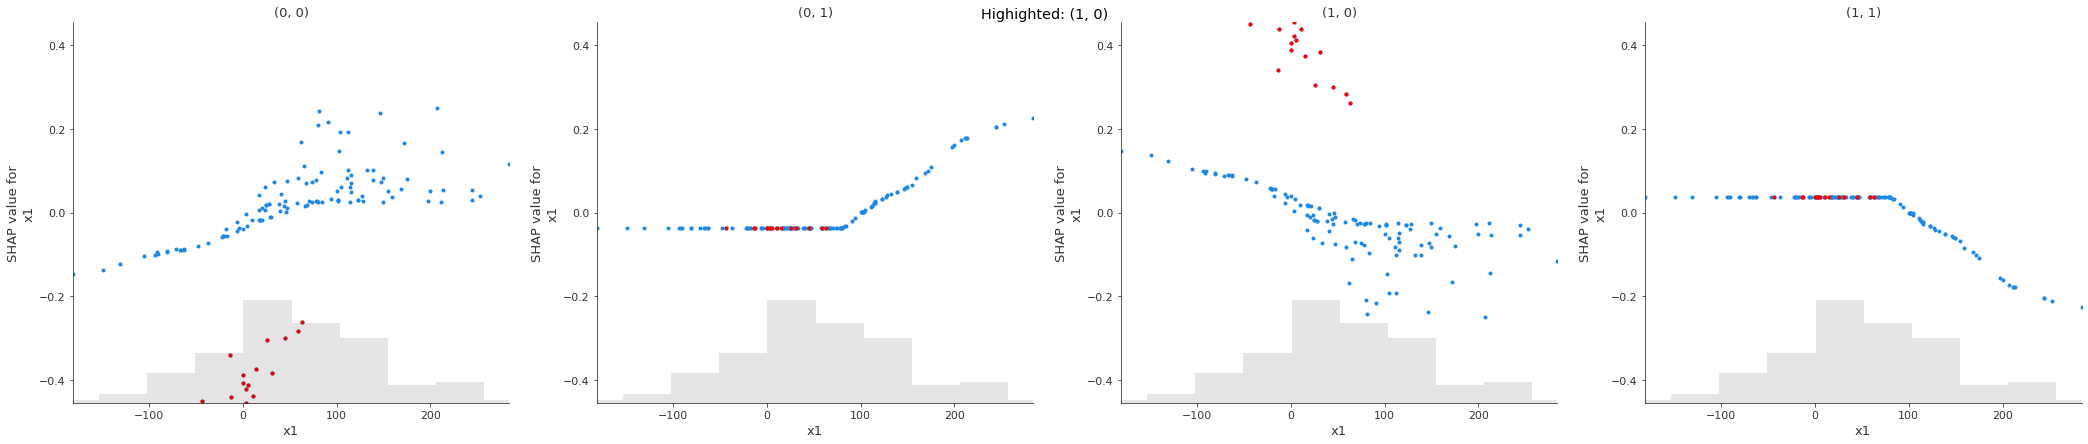

In [42]:
plot_next_feature()

In [43]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = 200
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",114,114


,before,after
"(0, 0)",NaN,15.0
"(1, 0)",15.0,NaN


In [46]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = -100
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",114.0,52
"(1, 0)",NaN,62


,before,after
"(1, 0)",15,15


### diro2c

In [47]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [48]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 14 s, sys: 98.6 ms, total: 14.1 s
Wall time: 14.3 s


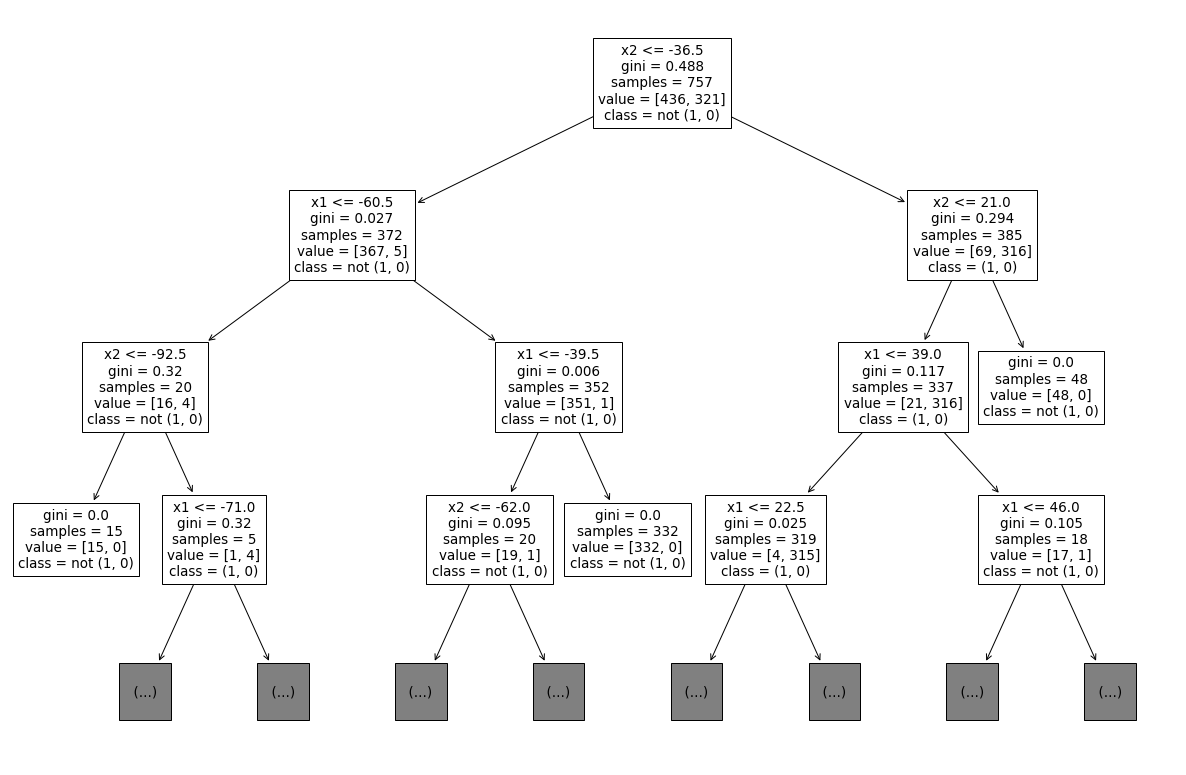

In [49]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

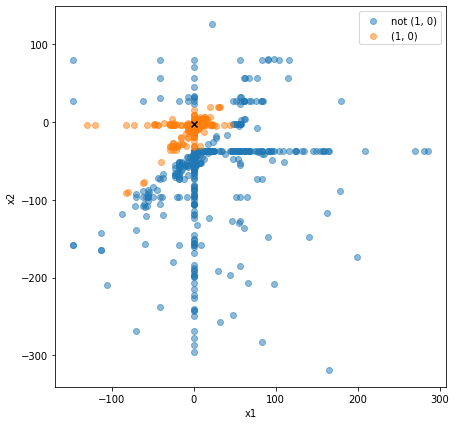

In [50]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)

## 2. Cluster

These feature value distributions are different locally compared to the global level:
- x2 only reaches from 21 upwards
- x1 reaches from -34 upwards

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x2 was lower, the effect would shift towards $(0,0)$: Setting it to -200 changes all predictions to this class.
- if x1 was lower, the effect would shift towards $(1,1)$: setting it to -100 changes all predictions of instances classified differently to this class and leaves others unchanged.

Using the local explanations I can interpret that:
- if x2 was higher, the effect would shift towards $(1,1)$: setting it to 200 changes all predictions of instances classified differently to this class and leaves others unchanged.
- if x1 was lower, the effect would shift towards $(1,1)$: setting it to 0 changes all predictions of instances classified differently to this class and leaves others unchanged.

In [51]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c2,0,22,0,149


In [52]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,171.000000,171.000000
mean,106.054097,92.775562
std,62.951537,47.947798
min,-34.549289,21.408908
25%,65.666989,54.637883
50%,102.564420,89.738143
75%,141.809815,116.996654
max,307.157526,258.940851


In [53]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = -200
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,22.0
"(0, 1)",22.0,NaN


,before,after
"(0, 0)",NaN,149.0
"(1, 1)",149.0,NaN


In [54]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = -100
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",22.0,NaN
"(1, 1)",NaN,22.0


,before,after
"(1, 1)",149,149


### SHAP-based Difference Classifier Explanations

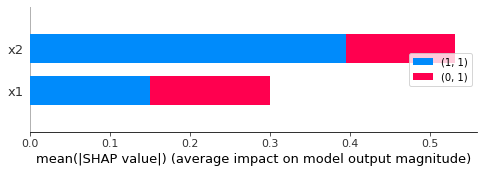

In [55]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

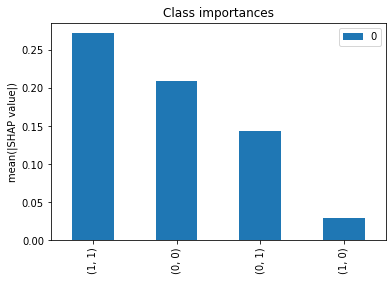

In [56]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [57]:
class_order = np.sort(class_order)

In [58]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]][:, :, class_order])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]][:, :, class_order], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

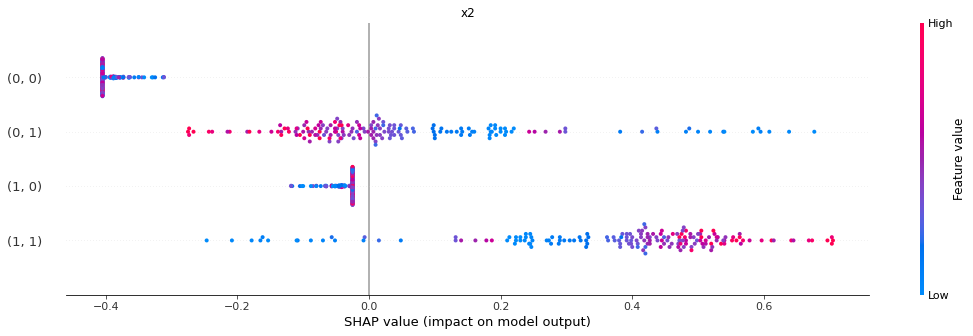

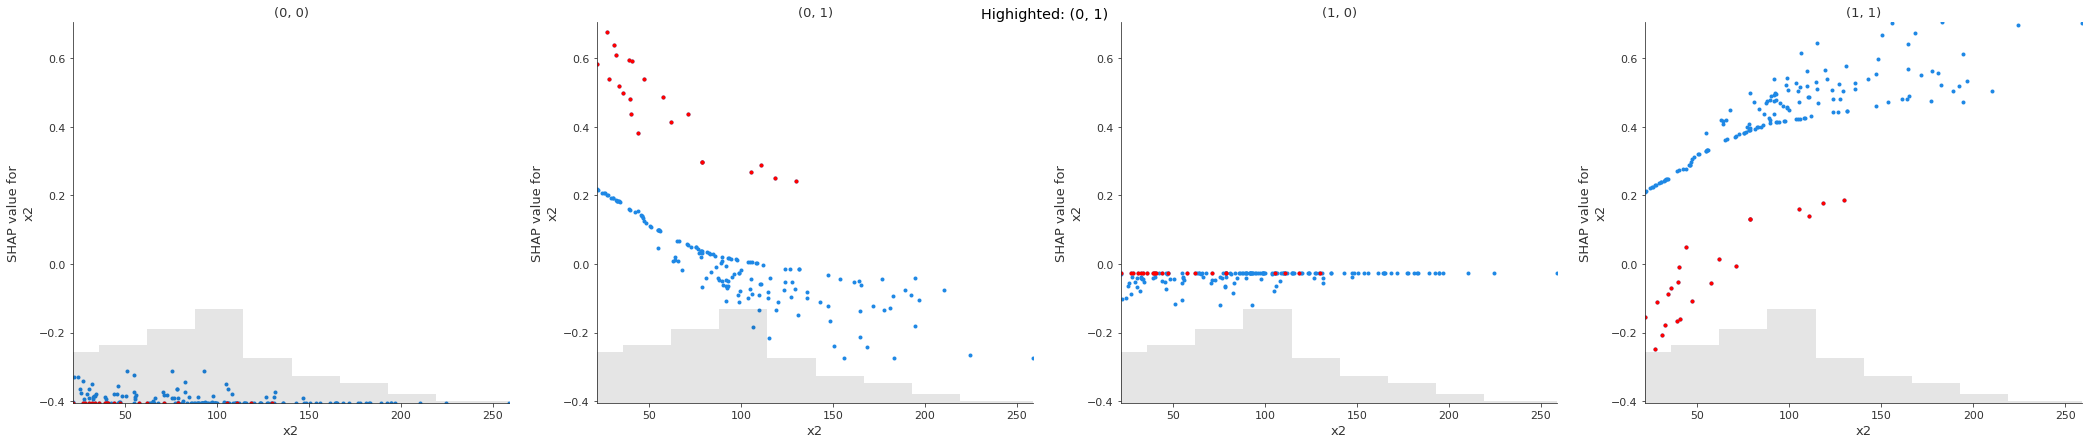

In [59]:
plot_next_feature()

In [61]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = 200
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",22.0,NaN
"(1, 1)",NaN,22.0


,before,after
"(1, 1)",149,149


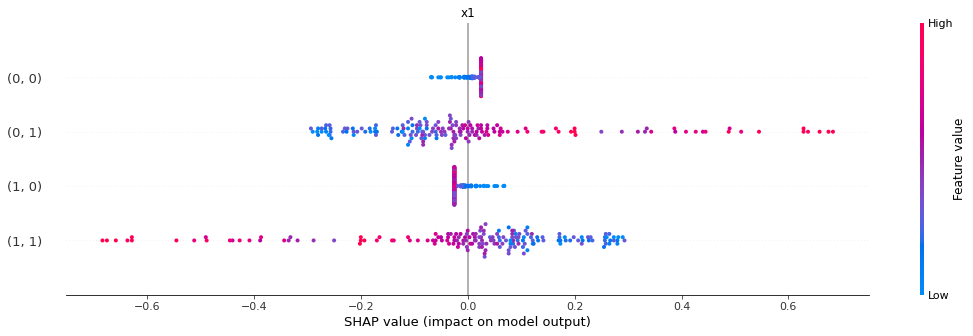

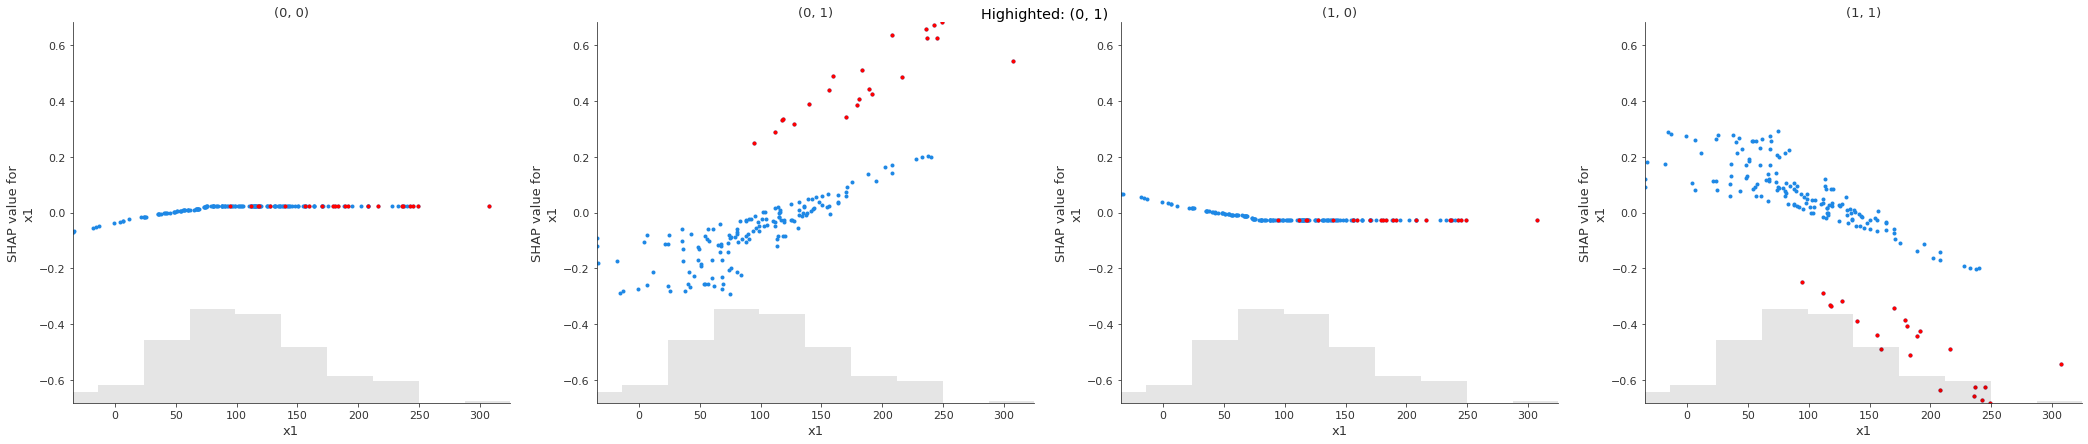

In [62]:
plot_next_feature()

In [64]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = 0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 1)",22.0,NaN
"(1, 1)",NaN,22.0


,before,after
"(1, 1)",149,149


### diro2c

In [65]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [66]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 13.9 s, sys: 94.8 ms, total: 14 s
Wall time: 14.1 s


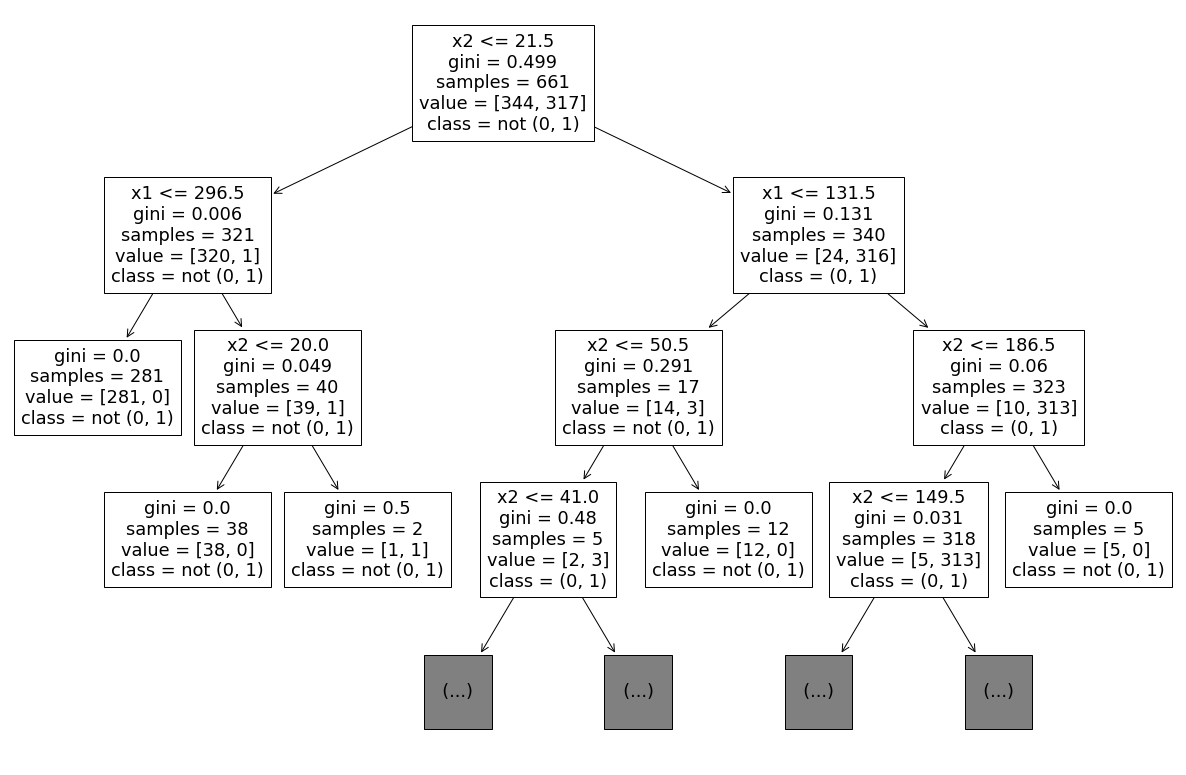

In [67]:
fig, ax = plt.subplots(figsize=(21, 14))
plot_diro2c_tree(explanation, max_depth=3)

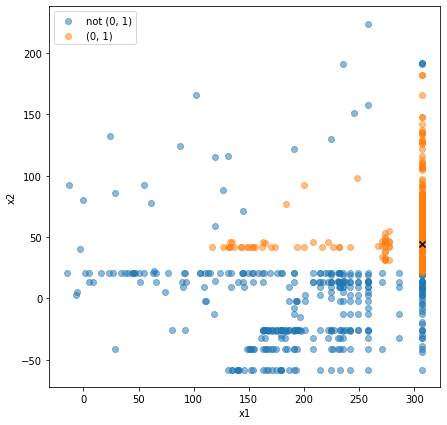

In [68]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)